In [1]:
import os
import shutil
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Paths
dataset_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Dataset/MRI Images' 
train_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/train'  
test_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/test'    

## Splitting Data Into Train and Test

In [4]:
# train-test split 
split_ratio = 0.8 

# Train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    
    if os.path.isdir(class_path):
        train_class_path = os.path.join(train_dir, class_folder)
        test_class_path = os.path.join(test_dir, class_folder)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        
        images = os.listdir(class_path)

        random.shuffle(images)
        split_point = int(len(images) * split_ratio)
        train_images = images[:split_point]
        test_images = images[split_point:]
        
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
        
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Train-test split complete!")

Train-test split complete!


# Loading Images and Labels

In [3]:
#  Loading images and label
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  
    batch_size=32,         
    label_mode='int',       
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 795 files belonging to 4 classes.
Found 201 files belonging to 4 classes.


In [4]:
# Class Names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Mild Dementia', 'Moderate Dementia', 'No Dementia', 'Severe Dementia ']


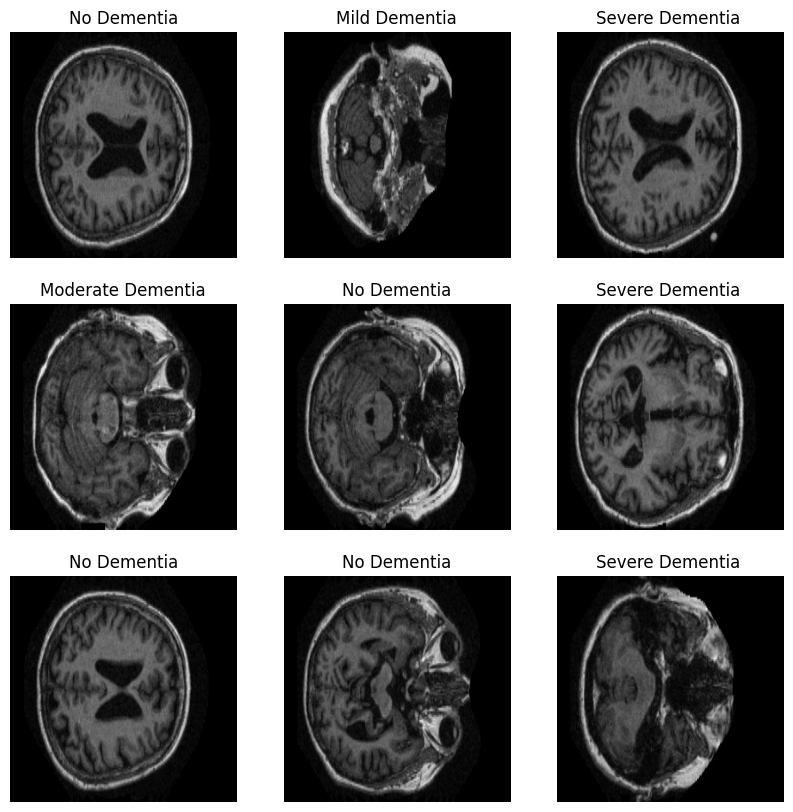

In [5]:
# Displaying Images
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8")) 
    plt.title(class_names[label_batch[i]]) 
    plt.axis("off")  
plt.show()

## Normalizing Images


In [34]:
# Normalize the image data
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [35]:
input_shape = (256, 256, 3)

# CNN Model 1

In [36]:
# CNN Model
model = Sequential()
model.add(Conv2D(32, (2, 2),activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2, 2),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 batch_normalization_9 (Bat  (None, 255, 255, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      4128      
                                                                 
 batch_normalization_10 (Ba  (None, 126, 126, 32)     

In [38]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [40]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15 
)

Epoch 1/15
25/25 [==============================] - 8s 320ms/step - loss: 0.5740 - accuracy: 0.7686 - val_loss: 10.7530 - val_accuracy: 0.2090
Epoch 2/15
25/25 [==============================] - 8s 320ms/step - loss: 0.5072 - accuracy: 0.7648 - val_loss: 6.6643 - val_accuracy: 0.3383
Epoch 3/15
25/25 [==============================] - 8s 302ms/step - loss: 0.5494 - accuracy: 0.7509 - val_loss: 3.1706 - val_accuracy: 0.6766
Epoch 4/15
25/25 [==============================] - 8s 302ms/step - loss: 0.4920 - accuracy: 0.7686 - val_loss: 2.4951 - val_accuracy: 0.7910
Epoch 5/15
25/25 [==============================] - 8s 300ms/step - loss: 0.5633 - accuracy: 0.7761 - val_loss: 3.4651 - val_accuracy: 0.7065
Epoch 6/15
25/25 [==============================] - 8s 303ms/step - loss: 0.5136 - accuracy: 0.7811 - val_loss: 6.6178 - val_accuracy: 0.5522
Epoch 7/15
25/25 [==============================] - 8s 309ms/step - loss: 0.4625 - accuracy: 0.8138 - val_loss: 7.0278 - val_accuracy: 0.5025
Epoch

## Model Metrics

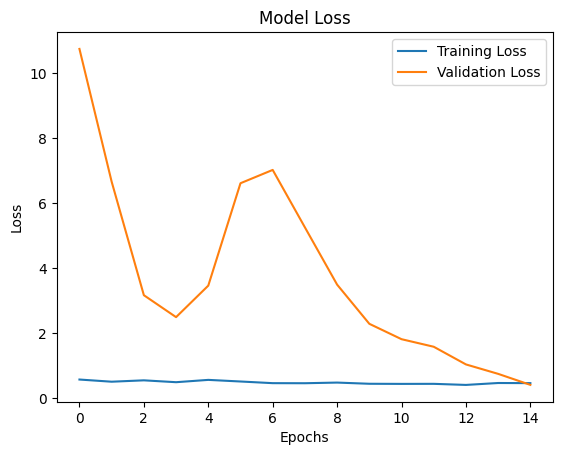

In [42]:
# Training & validation loss 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

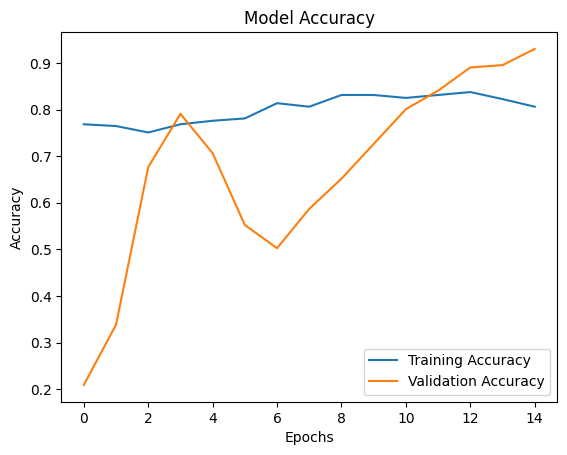

In [43]:
# Training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [44]:
# Metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Training Accuracy: {final_train_acc}")
print(f"Final Validation Accuracy: {final_val_acc}")

Final Training Loss: 0.4633010923862457
Final Validation Loss: 0.4098840355873108
Final Training Accuracy: 0.8062893152236938
Final Validation Accuracy: 0.93034827709198


7/7 [==============================] - 1s 65ms/step


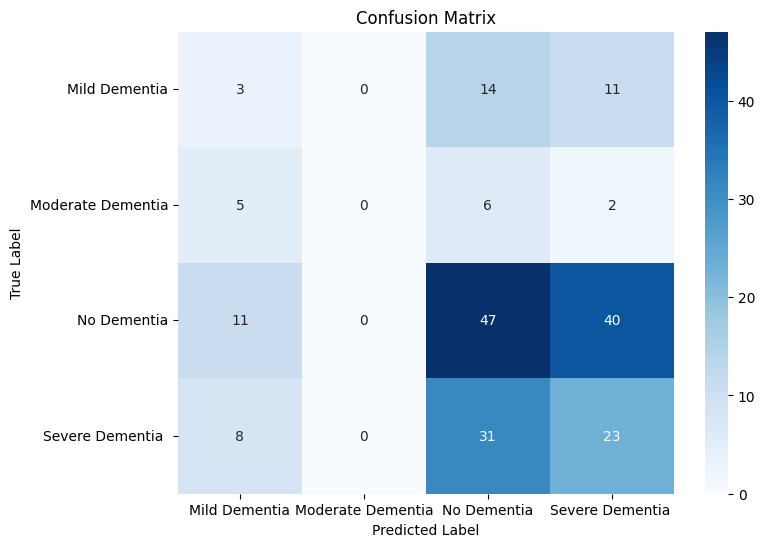

In [47]:
# Confusion Matrix
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()